# Recommender system

Recommender system using a simplified version of the dataset from the MELI Challenge 2020. To find similar items to a target item, first i will train a model, and next i will use the embedding vectors with KDTrees

### Drive mounting, defining functions and libraries loading

In [132]:
import pickle
import gzip
import json
import gc
import math
import random
import tensorflow as tf
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn import preprocessing
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
from google.colab.data_table import DataTable

In [105]:
from keras.layers import Input, Dense, Flatten, Input, Embedding, Add, Concatenate, Dropout
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow import keras
from keras.regularizers import l2

In [106]:
%%capture
!pip install funpymodeling
from funpymodeling.data_prep import todf
from funpymodeling.exploratory import freq_tbl, profiling_num,status

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import os
os.chdir('/content/drive/MyDrive/Cursos/DL360 N2')

#### Function to search for the k most similar items to a target item

In [109]:
def find_k_similar_items(embeddings, df_items_selec, encoded_id_to_check, number_of_similar_items, encoder):
  tree = spatial.KDTree(embeddings)

  # Searching in the tree
  dist, encoded_id = tree.query(embeddings[encoded_id_to_check], k=k_elements+1)
  
  # Creating most similiar item dataframe
  df_most_similar = pd.DataFrame({'dist':dist, 'encoded':encoded_id})

  # Deleting the item to check, and adding rank
  df_most_similar = df_most_similar[df_most_similar['encoded']!=encoded_id_to_check].copy()
  df_most_similar['rank'] = list(range(1, k_elements+1))

  # Searching for the id with the inverse encoder
  similar_item_id = encoder.inverse_transform(df_most_similar['encoded'])
  df_most_similar['item_id'] = similar_item_id

  # First the item that we want to check, and next there are the top items
  df_items_selec[df_items_selec['item_id'].isin(encoder.inverse_transform([encoded_id_to_check]))][['item_id','title', 'domain_id', 'price']]
  df_top_items=df_items_selec[df_items_selec['item_id'].isin(df_most_similar['item_id'])][['item_id','title', 'domain_id', 'price']]

  # Merging both in one dataframe
  return pd.merge(df_top_items, df_most_similar, on='item_id').sort_values('rank')

### Data Loading

Metadata loading

In [110]:
pkl_item_selec = '/content/drive/MyDrive/Cursos/DL360 N2/data/meli_files/df_item_selec.pkl'

with open(pkl_item_selec, "rb") as f:
    df_items_selec = pickle.load(f)

items_selection = df_items_selec['item_id'].tolist()

In [111]:
freq_tbl(df_items_selec['domain_id'])

,domain_id,frequency,percentage,cumulative_perc
0,MLB-CELLPHONES,38390,0.465610,0.465610
1,MLB-HEADPHONES,11328,0.137391,0.603001
2,MLM-CELLPHONES,8035,0.097452,0.700452
3,MLM-CELLPHONE_COVERS,7475,0.090660,0.791112
4,MLB-CELLPHONE_SCREENS,6595,0.079987,0.871099
5,MLM-HEADPHONES,5731,0.069508,0.940607
6,MLB-CELLPHONE_ACCESSORIES,3177,0.038532,0.979139
7,MLM-CELLPHONE_ACCESSORIES,1720,0.020861,1.000000


There are 8 categories, all related to cellphones

Training data loading

In [112]:
pkl_datos = "/content/drive/MyDrive/Cursos/DL360 N2/data/meli_files/data_seq.pkl"

with open(pkl_datos, "rb") as f:
  x_seq, y_seq = pickle.load(f)

In [113]:
x_seq

array([[      0, 1894398],
       [      0, 1730020],
       [1709387, 1983629],
       ...,
       [1702233,  165816],
       [ 235524, 1726723],
       [1399383,  492150]], dtype=int32)

In [114]:
y_seq

array([1591096, 1310157,  699581, ...,  242012,  485683, 2059288],
      dtype=int32)

This training data was obtained forming sequencies of 3 items. For example, if i have 3 items, X, Y and Z. If X and Y was watched, then the next item that should be watched will be Z. If X and Z was watched, then the next item that should be watched will be Y. Finally, if Y and Z was watched, then the next item that should be watched will be X

So, x_seq is a matrix of (n_elements, 2) and Y a vector of n_elements

In [115]:
print(x_seq.shape)
print(y_seq.shape)

(44129, 2)
(44129,)


### Encoding variables

<h4>X encoding</h4>

In [116]:
dim1, dim2 = x_seq.shape

seq_x_flat = x_seq.flatten()

In [117]:
le_x = preprocessing.LabelEncoder()

le_x.fit(seq_x_flat)

seq_x_flat_encoded = le_x.transform(seq_x_flat)

In [118]:
seq_x_encoded = seq_x_flat_encoded.reshape([dim1, dim2])
seq_x_encoded

array([[    0, 12641],
       [    0, 11521],
       [11408, 13229],
       ...,
       [11361,  1076],
       [ 1508, 11496],
       [ 9238,  3157]])

<h4>Y encoding</h4>

In [119]:
le_y = preprocessing.LabelEncoder()

le_y.fit(y_seq)

seq_y_encoded = le_y.transform(y_seq)
seq_y_encoded

array([4869, 4007, 2093, ...,  697, 1388, 6352])

In [120]:
N_UNIQUE_INPUT = seq_x_flat_encoded.max()+1
N_UNIQUE_Y_ITEMS = seq_y_encoded.max()+1
SEQ_LEN = 2

print(N_UNIQUE_INPUT, N_UNIQUE_Y_ITEMS, SEQ_LEN)

14025 6488 2


### Models Creation

Defining the model

In [121]:
input = Input(shape=(SEQ_LEN,), name='item') 

x = Embedding(input_dim = N_UNIQUE_INPUT, 
                        output_dim = 20, 
                        input_length = SEQ_LEN, name='embedding')(input)

x = keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(x)

x = Dropout(0.3)(x)

x = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)

x = Dropout(0.3)(x)

x = Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)

out_num = Dense(N_UNIQUE_Y_ITEMS, activation='softmax')(x)

model_final = Model(inputs=input, outputs=out_num)

In [122]:
model_final.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item (InputLayer)            [(None, 2)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 2, 20)             280500    
_________________________________________________________________
lambda_3 (Lambda)            (None, 20)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528 

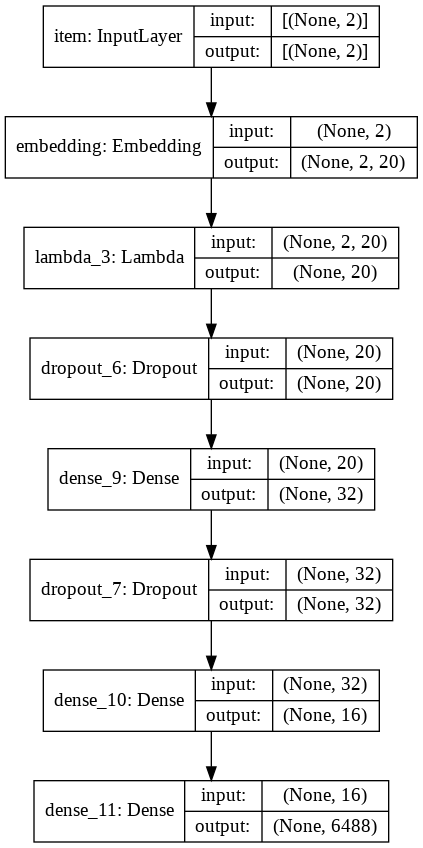

In [123]:
keras.utils.plot_model(model_final, show_shapes=True)

Defining a decaying learning rate and compiling the model

In [124]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 6.5e-2,
    decay_steps = 10000, # cant. casos train / batch size
    decay_rate = 0.8, 
    staircase = False)

In [125]:
model_final.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = 'accuracy')

In [126]:
history = model_final.fit(x=seq_x_encoded, y=seq_y_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1104/1104 [==============================] - 13s 11ms/step - loss: 8.7089 - accuracy: 0.0063 - val_loss: 8.5019 - val_accuracy: 0.0105
Epoch 2/10
1104/1104 [==============================] - 12s 11ms/step - loss: 8.2161 - accuracy: 0.0086 - val_loss: 8.4690 - val_accuracy: 0.0105
Epoch 3/10
1104/1104 [==============================] - 12s 11ms/step - loss: 8.2298 - accuracy: 0.0075 - val_loss: 8.4610 - val_accuracy: 0.0105
Epoch 4/10
1104/1104 [==============================] - 12s 11ms/step - loss: 8.2102 - accuracy: 0.0086 - val_loss: 8.4710 - val_accuracy: 0.0105
Epoch 5/10
1104/1104 [==============================] - 12s 11ms/step - loss: 8.2105 - accuracy: 0.0072 - val_loss: 8.4718 - val_accuracy: 0.0105
Epoch 6/10
1104/1104 [==============================] - 12s 11ms/step - loss: 8.2074 - accuracy: 0.0085 - val_loss: 8.4830 - val_accuracy: 0.0105
Epoch 7/10
1104/1104 [==============================] - 12s 11ms/step - loss: 8.2072 - accuracy: 0.0082 - val_loss: 8.4956 -

There is a little overfitting, so the model can be improved

### Finding similar items with embeddings

In [127]:
embeddings = model_final.layers[1].get_weights()[0]
embeddings.shape

(14025, 20)

In [128]:
embeddings

array([[ 0.00539593, -0.3465137 , -0.42117178, ...,  0.50988895,
         0.33158475,  0.36881217],
       [-0.02389205,  0.0484152 , -0.02849256, ..., -0.03936899,
         0.0093295 ,  0.03769249],
       [ 0.04552079, -0.0081803 , -0.04791714, ...,  0.03126779,
        -0.01493918,  0.0293668 ],
       ...,
       [-0.00745691, -0.01557352,  0.00762706, ..., -0.01756407,
        -0.0134827 ,  0.04410884],
       [-0.00051261, -0.0242442 , -0.02406838, ...,  0.00826316,
         0.01602731,  0.04054907],
       [-0.01483037,  0.02648458,  0.01083311, ..., -0.01370523,
         0.02716651, -0.03856451]], dtype=float32)

From the model, i see the embedding layer

<h3>Using KDTree to find vectors</h3>

Saving all the data

In [129]:
prep_files='/content/drive/MyDrive/Cursos/DL360 N2/data/meli_files/prep_files.pkl' 

In [130]:
if False:
  with open(prep_files, "wb") as f:
      pickle.dump([df_items_selec, le_x, embeddings],f)
else:
  with open(prep_files, "rb") as f:
    df_items_selec, le_x, embeddings = pickle.load(f)

Using the function to find the k most similar items to a target item

In [131]:
find_k_similar_items(embeddings, df_items_selec, 8321, 3, le_x)

,item_id,title,domain_id,price,dist,encoded,rank
0,1317531,Moto G7 Play Dual Sim 32 Gb Índigo Oscuro 2 Gb...,MLM-CELLPHONES,2997.00,0.200620,8700,1
1,1849208,Celular Xiaomi Redmi Note 7 128 Gb /4 Gb Branc...,MLB-CELLPHONES,1199.00,0.507660,12322,2
2,925606,Celular Xiaomi Redmi Note 7 128 Gb / 4 Gb Bran...,MLB-CELLPHONES,1230.00,0.548605,6113,3


Here i see, in order, the similar items to 'Moto G7 Power Dual Sim 64 Gb Marine Blue 4 Gb Ram'